# Bagtanker
Det følgende afsnit er en overordnet beskrivelse af hvad jeg har i tankerne for konkurrencen indenfor Denoising Diffusion Probabilistic Models (DDPM) (Også bedre kendt som Diffusion modeller).

I denne notebook har jeg implementeret en DDPM der er trænet på Quick Draw! datasættet som vi også brugte sidste år. En mindre udfordring jeg har haft med at lave dette generelt, er at de teknikker som der bruges er lidt komplekse og bliver ikke dækket af resten af uddannelses forløbbet. Derfor ser jeg at den bedste måde at gøre konkurrencen til noget som både passer ind til dem der bare gerne vil lære samt dem der også gerne vil vinde en konkurrence, er ved at lave en notebook der basalt set går igennem alle de forskellige dele, og så have en python script ved siden af som de så kan bruge til at træne deres egen model og sende ind til konkurrencen.

Flowet bliver så at der anbefales at deltagerne går igennem denne notebook først og danner sig et indblik til hvordan de forskellige ting fungerer. Og så bagefter går i gang med konkurrencen. 

I notebooken, har jeg med vilje gemt ting såsom dataloaderen væk, da jeg føler at det er ligegyldigt for dem at vide hvordan den fungerer. Plus så ungår vi unødvendig smerte hvis nu de kommer til at ændre noget derinde og resten af koden ikke fungerer lige pludseligt. 

Alt er ligenu meget placeholder, jeg vil meget gerne ændre koden så den er mere intuitiv når jeg har lidt mere tid. Strukturen kommer meget til at være: tekst der beskriver hvad der sker i næste kodeblok, og så kodeblok osv.

Udover at beskrive hvad hver kodeblok, så vil jeg også gerne tilføje en eller anden form for fortælling i forhold til det hele. Såsom motivation bag en generativ model, hvad kan den løse, hvad er dets svagheder som model osv. Så altså give en så god introduktion og forståelse til verdenen af generativ modellering.

# Pakker
Pakker der skal bruges under træningen og evalueringen af modellen. Kommer nok lidt tekst til torch, men vil gerne holde det til det minimumme.

In [1]:
# Pakker der skal importeres (og derfor også installeres)
import torch
import torch.nn as nn
import typing as T # Tilføjer typing senere hvis det giver mening
from tqdm import tqdm
from torch.nn import functional as F
from torchvision.utils import save_image

# Kode der er 'gemt' væk
from QuickDraw.get_data import get_dataset, plot_doodles # Dataloaderen
from utils.nets import Unet # Det neuralle netværk

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


# Data visualisering
Nedenfor bliver dataen kaldt og loaded. For at undgå for meget data variation (som DDPM har det svært med), så kalder vi kun 5 forskellige data labels til træningen. Her er der valgt kategorier som er både simple (fish, apple, bread og mushroom) og så et komplex label (cat).

Loading data...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading data...:  20%|██        | 1/5 [00:10<00:41, 10.41s/it]

Loading data...:  40%|████      | 2/5 [00:21<00:32, 10.92s/it]

Loading data...:  60%|██████    | 3/5 [00:31<00:21, 10.51s/it]

Loading data...:  80%|████████  | 4/5 [00:44<00:11, 11.33s/it]

Loading data...: 100%|██████████| 5/5 [00:56<00:00, 11.28s/it]


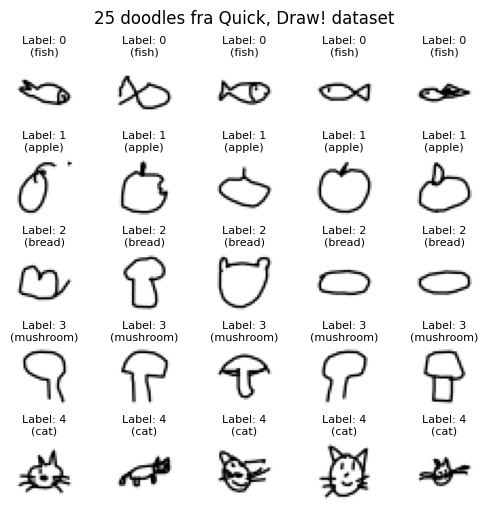

In [2]:
# Get data
TEGNINGER = [
                "fish", "apple", "bread", "mushroom", "cat"
            ]

training_dataset, validation_dataset = get_dataset(TEGNINGER, n_samples=30000 * len(TEGNINGER), verbose=True)
plot_doodles(TEGNINGER)

D = next(iter(training_dataset))[0].shape[2] # Rykker nok til et andet sted, men det handler om #features som dataen har (antal pixels)

# Model definition

Det er så her hvor tingene bliver kringlet. 

## Træning
Som modellen er lige nu skrevet op, så bliver der defineret en funktion der beregner Evidence Lower Bound (ELBO) af modellens output. Men dette er ikke som sådan et tal der beregnes og derefter optimeres på, men hellere et form for 'krav' for modellen. Her i modellen så bliver den meget enkelt beregnet ved følgende process:
1. Tag input billeder fra datasæt
2. Sample et random værdi af $t$, hvor man kan se dette tal som hvor meget støj tilføjer man til input billederne
3. Mix input billeder med støj via formlen $\sqrt{\bar \alpha_t} \mathrm x + \sqrt{(1 - \bar \alpha_t)} \epsilon_0$
    * Hvor $\epsilon_0$ følger en normal/gaussisk fordeling (altså er den støj der tilføjes til billederne)
4. Smid det støjede billede gennem et netværk, som i dette tilfælde er et Unet struktur
5. Find norm forskellen mellem netværkets output billede og det tilfældige støj $\epsilon_0$
6. Tag gradient descent (dansk?) på normen

Så altså modellen bliver egentlig ikke trænet til at outputte et billede, men hellere bliver trænet til at fjerne støj fra et billede således at billedet uden støj ligner et billede i det originale data rum. Ved at optimerer modellen på dette, så optimerer man også dets ELBO værdi samtidigt. Grundet til at man tager udgangspunkt i støjen og ikke selve billedet er så at ved at kun kigge på støj opnår man en generativ model i stedet for en mapping funktion i.e. $f(x) = y$.

Årsagen bag at man randomly sampler værdier af $t$ er at man så træner modellen til at kunne håndtere en variende mængde af støj. Desto lavere en $t$ værdi, desto mere af den originale billede bliver smidt ind til netværket, og omvendt desto højere en $t$ værdi desto mere støj bliver tilføjet. 

Lige pt i denne version har jeg gemt Unet væk i en seperat fil, dette er grundet at det ikke er super vigtig at vise koden i min personlige mening. Samtidig så vil jeg helst have at de roder med hyperparametrene før de roder med netværket. Kan dog godt tilføjes igen. 

# Sampling
Konceptet bag samplingen er også kringlet defineret. Dog kan den simplificeres til følgende trin:
1. Definerer ren støj, altså Gaussisk støj
2. For hver $t \in [T, T-1, T-2, T-3, \dots, 2, 1]$ smid støjen gennem modellen
3. Til sidst outputter den så et billede ud fra støjen

For så at træne modellen så man kan specifikt bede om visse labels, så bliver labels fra dataen også one-hot encoded og modellen bliver trænet med denne encoding. 

En ekstra ting som kan ses som en hyperparameter, er at man gerne vil undgå at labels encodingen dominere outputtet, så kan man 'maskere' nogle data input labels ved at sætte dem til værdien 0. Procentdelen af labels per batch er så den hyperparameter man kan udforske.

In [3]:
class DDPM(nn.Module):
    def __init__(self, network, beta_1=1e-4, beta_T=2e-2, T=100, p_unconditional=1.):
        """
        Initialize a DDPM model.

        Parameters:
        network: [nn.Module]
            The network to use for the diffusion process.
        beta_1: [float]
            The noise at the first step of the diffusion process.
        beta_T: [float]
            The noise at the last step of the diffusion process.
        T: [int]
            The number of steps in the diffusion process.
        """
        super(DDPM, self).__init__()
        self.network = network
        self.beta_1 = beta_1
        self.beta_T = beta_T
        self.T = T
        self.p_unconditional = p_unconditional

        self.beta = nn.Parameter(torch.linspace(beta_1, beta_T, T), requires_grad=False)
        self.alpha = nn.Parameter(1 - self.beta, requires_grad=False)
        self.alpha_cumprod = nn.Parameter(self.alpha.cumprod(dim=0), requires_grad=False)

    def one_hot(self, batch_size, labels, train):
        """
        One-hot encode a tensor of labels.

        Parameters:
        labels: [torch.Tensor]
            The labels to one-hot encode.
        Returns:
        [torch.Tensor]
            The one-hot encoded labels.
        """
        if not torch.is_tensor(labels):
            labels = torch.tensor([labels], dtype=torch.long).to(self.alpha.device)
            labels = labels.repeat(batch_size // labels.size(0))

        if train:
            mask = torch.rand(labels.shape[0], device=device) > self.p_unconditional
            labels = torch.where(mask.unsqueeze(-1), labels, torch.zeros_like(labels))

        return F.one_hot(labels, num_classes=5).squeeze(1).to(self.alpha.device)
    
    def negative_elbo(self, x, labels):
        """
        Evaluate the DDPM negative ELBO on a batch of data.

        Parameters:
        x: [torch.Tensor]
            A batch of data (x) of dimension `(batch_size, *)`.
        Returns:
        [torch.Tensor]
            The negative ELBO of the batch of dimension `(batch_size,)`.
        """
        
        # t is uniformly sampled from [1, T]
        t = torch.randint(1, self.T, (x.shape[0], 1)).to(self.alpha.device)
        normalized_t = (t + 1) / (self.T + 1)
        labels = self.one_hot(x.shape[0], labels, train=True)
        # epsilon_params is a function approximator intended to predict epsilon from x_t
        epsilon = torch.randn_like(x).to(self.alpha.device)
        epsilon_params = self.network(torch.sqrt(self.alpha_cumprod[t]) * x + torch.sqrt(1 - self.alpha_cumprod[t]) * epsilon, normalized_t, labels)

        # The squared distance
        neg_elbo = torch.norm(epsilon - epsilon_params, dim=1)**2

        return neg_elbo

    def sample(self, shape, labels):
        """
        Sample from the model.

        Parameters:
        shape: [tuple]
            The shape of the samples to generate.
        Returns:
        [torch.Tensor]
            The generated samples.
        """
        # Sample x_t for t=T (i.e., Gaussian noise)
        x_t = torch.randn(shape).to(self.alpha.device)

        labels = self.one_hot(shape[0], labels, train=False)

        # Sample x_t given x_{t+1} until x_0 is sampled
        for t in range(self.T-1, -1, -1):
            if t > 1:
                z = torch.randn(shape).to(self.alpha.device)
            else:
                z = 0

            scale = 1 / torch.sqrt(self.alpha[t])
            epsilon_params = self.network(x_t, torch.tensor([(t + 1)/(self.T + 1)] * shape[0]).unsqueeze(1).to(self.alpha.device), labels)

            parentheses = x_t - ((1 - self.alpha[t])/(torch.sqrt(1 - self.alpha_cumprod[t]))) * epsilon_params

            const = torch.sqrt(self.beta[t]) * z
            x_t = scale * parentheses + const

        return x_t
    
    def forward(self, x, labels):
        return self.negative_elbo(x, labels).mean()

In [4]:
def loss_fn(model, x, labels): # Dum måde at gøre det på, laver det om på et tidspunkt
    return model(x, labels)

# Train loop

Meget standard træningsloop i at man tager data i batches og smider ind i modellen. Derefter tager man loss funktionen og laver gradient descent. Den eneste store forskel fra for eksempel en classifier model er at man ikke bruger test data da det ikke giver mening i forhold til en generativ model.

In [5]:
def train(model, optimizer, data_loader, epochs, device):
    """
    Function to train the DDPM model.

        Parameters:
        model: [nn.Module]
            The model to train.
        optimizer: [torch.optim.Optimizer]
            The optimizer to use for training.
        data_loader: [DataLoader]
            The data loader to use for training.
        epochs: [int]
            The number of epochs to train.
        device: [torch.device]
            The device to use for training: Supports CPU, CUDA and MPS
    """
    
    model.train()

    total_steps = len(data_loader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training", position=0, leave=True)
    for epoch in range(epochs):
        for i, (x, labels) in enumerate(data_loader):
            images = x.to(device)
            images = images.view(images.size(0), -1)
            labels = labels.long().to(device)
            optimizer.zero_grad()
            loss = model(images, labels)
            loss.backward()
            optimizer.step()

            progress_bar.update(1)
            progress_bar.set_postfix({"Loss": loss.item()}, epoch=f"{epoch+1}/{epochs}")
    progress_bar.close()

# Hyperparametre

Det er her hvor deltagerne kan råde med modellen primært. Senere hen kan der udvides med hvad specifikt $\beta_1$ og $\beta_T$ specifikt betyder for modellen. 15 epochs burde tage cirka 10 minutter på en GPU.

In [ ]:
# Hyperparametre
antal_billeder = 30000
batch_size = 64
optimizer = 'Adam' # Tilføjer andre senere
learning_rate = 1e-4
beta_1 = 1e-4
beta_T = 2e-2
T = 1000
p_uncod = 0.1

model_navn = 'test_model.pt'
sample_navn = 'test.png'

model = DDPM(network=Unet(D, len(TEGNINGER)), beta_1=beta_1, beta_T=beta_T, T=T, p_unconditional=p_uncod).to(device)

if optimizer == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Definer data loaders for træning
training_data_loader, validation_data_loader = get_dataset(TEGNINGER, n_samples=antal_billeder * len(TEGNINGER), batch_size=batch_size, verbose=True)

train(model, optimizer, training_data_loader, epochs=15, device=device)

torch.save(model.state_dict(), model_navn)
print(f"Modellen er gæmt som filen: {model_navn}")

Training:   1%|          | 216/35160 [00:03<07:55, 73.46it/s, Loss=395, epoch=1/15]    

# Visualisering af resultater
Simpel kode til at visualiser lige mange billeder af hvert label.

In [9]:
def sample_images(model, samples_name):

    model.eval()
    with torch.no_grad():
        samples = torch.zeros((100, 1, 28, 28)).to(device)
        for i, label in enumerate(TEGNINGER):
            sample_label = model.sample((100 // len(TEGNINGER), D), i).cpu().reshape(-1, 1, 28, 28) # Til billed dimensioner
            samples[i*100//len(TEGNINGER):(i+1)*100//len(TEGNINGER)] = sample_label
        
        # Gå tilbage til [-1, 1] til [0, 1]
        samples = samples / 2 + 0.5
        save_image(samples, samples_name, nrow=10)
        print(f"Samples er gemt som filen: {samples_name}")

sample_images(model = model, samples_name = sample_navn)

Samples er gemt som filen: test.png
